# Solving a SOLA problem using the Problem class

The Problem class in the SOLA_DLI file contains all the tools for solving a SOLA problem within the "property bounds perspective". We start as usual by importing the needed packages

In [31]:
from core.main_classes.domains import HyperParalelipiped
from core.main_classes.spaces import PCb, DirectSumSpace, RN
from core.aux.normal_data import load_normal_data
from core.main_classes.functions import *
from core.main_classes.mappings import *
from core.main_classes.SOLA_DLI import Problem
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

# Set global parameters for matplotlib
plt.rcParams.update({'font.size': 15})  # Set default font size
plt.rcParams['axes.linewidth'] = 1.5  # Set the thickness of the axes lines


Before even attempting to SOLVE a SOLA problem we must first define the mappings and spaces that we will work in. We will build these mathematical components one by one starting with the model space. 

The lines of codes in the "Edit regions" can be modified to explore variations of the given default SOLA problem.

In [32]:
####################
# Create model space
####################
# Edit region -------------
physical_parameters = ['vs', 'vp']

# Edit region -------------

physical_parameters_symbols = {'vs': '$\delta lnv_s$', 'vp': '$\delta lnv_p$', 'rho': '$\delta ln \\rho$'}
no_of_params = len(physical_parameters)
EarthDomain = HyperParalelipiped(bounds=[[0, 6371]], fineness=1000)
constituent_models_spaces = [PCb(domain=EarthDomain) for _ in physical_parameters]
# Create a dictionary with physical_parameters as keys
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
M = DirectSumSpace(tuple(constituent_models_spaces))

Then the data space. This is also where we iport the sensitivity kernels.

In [33]:
###################
# Create Data space
###################
# Edit region -------------
data_directory = '/home/adrian/PhD/BGSOLA/SOLA_DLI/kernels_modeplotaat_Adrian'
which_data = list(np.arange(0, 143))
# Edit region -------------

# Import sensitivity data
how_many_data = len(which_data)
raw_sensitivity_dict = {}
raw_sensitivity_domains_dict = {}
for param in physical_parameters:
    raw_sensitivity_domain, raw_sensitivity = load_normal_data(param, data_directory)
    raw_sensitivity_dict[param] = np.array(raw_sensitivity)[which_data]
    if param not in raw_sensitivity_domains_dict:
        raw_sensitivity_domains_dict[param] = raw_sensitivity_domain
domain_resolution = (raw_sensitivity_domain[1] - raw_sensitivity_domain[0])/np.abs(np.max(raw_sensitivity_domain))
D = RN(dimension=how_many_data)

The the model-data mapping.

In [34]:
###########################
# Create model-data mapping 
###########################
# Make them into functions via interpolation
sensitivity_dict = {}
for param in physical_parameters:
    sensitivity_dict[param] = []
    for discrete_sensitivity_kernel in raw_sensitivity_dict[param]:
        sensitivity_dict[param].append(Interpolation_1D(values=discrete_sensitivity_kernel,
                                                        raw_domain=raw_sensitivity_domains_dict[param],
                                                        domain=EarthDomain))
constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=D, 
                                        kernels=sensitivity_dict[param]) for param in physical_parameters]
mappings_dict = {param: mapping for param, mapping in zip(physical_parameters, constituent_mappings)}
G = DirectSumMapping(domain=M, codomain=D, mappings=tuple(constituent_mappings))

In [35]:
###################################
# Create property mapping and space
###################################
# Edit region -------------
target_types = {'vs': Gaussian_1D,
                'vp': Null_1D,
                'rho': Null_1D} # MODIFY BELOW AS WELL!!!
N_enquiry_points = 20
N_spreads = 20
min_spread = np.max([1e-3, 10*domain_resolution]) # The spread is as percentage of total domain
max_spread = 1
# Edit region -------------
N_targets = N_enquiry_points * N_spreads
enquiry_points = np.linspace(EarthDomain.bounds[0][0], 
                             EarthDomain.bounds[0][1], 
                             N_enquiry_points)
spreads = np.logspace(np.log10(min_spread), np.log10(max_spread), N_spreads) * EarthDomain.bounds[0][1]
combinations = list(product(enquiry_points, spreads))
enquiry_points_list, spreads_list = zip(*combinations)
enquiry_points_list = list(enquiry_points_list)
spreads_list = list(spreads_list)
P = RN(dimension=N_targets)
targets_dict = {}
for param, target_type in target_types.items():
    targets_dict[param] = []
    for enquiry_point, spread in combinations:
        if target_type == Gaussian_1D: # MODIFY HERE THE SPECIAL TARGET AS WELL!!!!
            targets_dict[param].append(target_type(domain=EarthDomain,
                                                center=enquiry_point,
                                                width=spread))
        else: 
            targets_dict[param].append(target_type(domain=EarthDomain))
constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=P, 
                                        kernels=targets_dict[param]) for param in physical_parameters]
T = DirectSumMapping(domain=M, codomain=P, mappings=tuple(constituent_mappings))

In [36]:
# Create color Palette
colors = sns.color_palette('YlGnBu', n_colors=100)

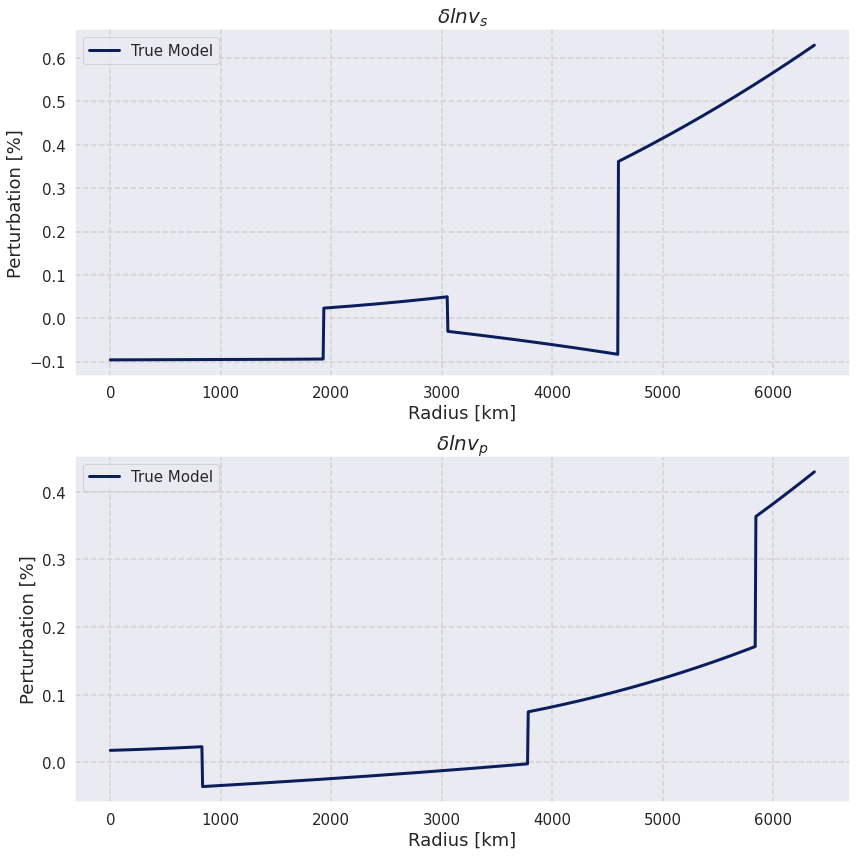

In [37]:
%matplotlib inline

#################################
# Create fake true model and data
#################################
true_model = M.random_member(args_list=[(4,), (3,), (13,)])
data = G.map(true_model)

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))

# Check if there's only one physical parameter
if len(physical_parameters) == 1:
    axes.plot(EarthDomain.mesh, true_model[0].evaluate(EarthDomain.mesh)[1], 
              label='True Model', color=colors[99], linewidth=3)
    axes.set_title(physical_parameters_symbols[physical_parameters[0]], fontsize=20)
    axes.set_xlabel('Radius [km]', fontsize=18)
    axes.set_ylabel('Perturbation [%]', fontsize=18)
    axes.tick_params(axis='both', which='major', labelsize=15)
    axes.legend(fontsize=15)
    axes.grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
else:
    for i, (submodel, physical_parameter) in enumerate(zip(true_model, physical_parameters)):
        axes[i].plot(EarthDomain.mesh, submodel.evaluate(EarthDomain.mesh)[1], 
                     label='True Model', color=colors[99], linewidth=3)
        axes[i].set_title(physical_parameters_symbols[physical_parameter], fontsize=20)
        axes[i].set_xlabel('Radius [km]', fontsize=18)
        axes[i].set_ylabel('Perturbation [%]', fontsize=18)
        axes[i].tick_params(axis='both', which='major', labelsize=15)
        axes[i].legend(fontsize=15)
        axes[i].grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('truth.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()


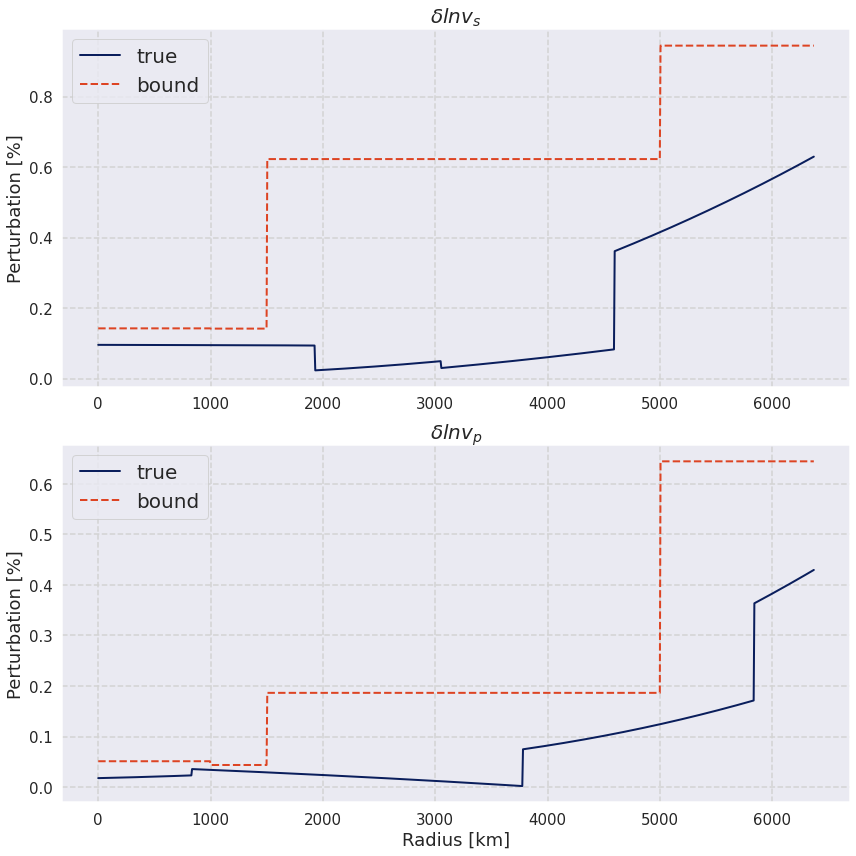

In [38]:
####################
# Compute norm bound
####################
# Edit region -------------
# Places where the true model will be evaluated
intervals = np.array([0,1000, 1500, 5000, EarthDomain.bounds[0][1]])
# Edit region -------------
upper_bounds = []
for model in true_model:
    values = np.abs(model.evaluate(intervals[1:])[1])*1.5
    upper_bound = Piecewise_1D(domain=model.domain,
                               intervals=intervals,
                               values=values)
    upper_bounds.append(upper_bound)
norm_bound = M.norm(tuple(upper_bounds))

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))
if len(physical_parameters) == 1:
    for i, (upperbound, submodel, physical_parameter) in enumerate(zip(upper_bounds, true_model, physical_parameters)):
        axes.plot(EarthDomain.mesh, np.abs(submodel.evaluate(EarthDomain.mesh)[1]), 
                label='true', color=colors[99], linewidth=2)
        axes.plot(EarthDomain.mesh, upperbound.evaluate(EarthDomain.mesh)[1], 
                label='bound', color='#dd4423', linestyle='--', linewidth=2)
        # Set title and labels
        axes.set_title(physical_parameters_symbols[physical_parameter], fontsize=20)
        axes.set_ylabel('Perturbation [%]', fontsize=18)
        # Set tick parameters
        axes.tick_params(axis='both', which='major', labelsize=15)
        # Add legend
        axes.legend(fontsize=12)
        axes.grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
        axes.legend(fontsize=20)
else:
    for i, (upperbound, submodel, physical_parameter) in enumerate(zip(upper_bounds, true_model, physical_parameters)):
        axes[i].plot(EarthDomain.mesh, np.abs(submodel.evaluate(EarthDomain.mesh)[1]), 
                label='true', color=colors[99], linewidth=2)
        axes[i].plot(EarthDomain.mesh, upperbound.evaluate(EarthDomain.mesh)[1], 
                label='bound', color='#dd4423', linestyle='--', linewidth=2)
        # Set title and labels
        axes[i].set_title(physical_parameters_symbols[physical_parameter], fontsize=20)
        axes[i].set_ylabel('Perturbation [%]', fontsize=18)
        # Set tick parameters
        axes[i].tick_params(axis='both', which='major', labelsize=15)
        # Add legend
        axes[i].legend(fontsize=12)
        axes[i].grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
        axes[i].legend(fontsize=20)
plt.xlabel('Radius [km]', fontsize=18)
plt.tight_layout()
plt.savefig('bound.png', bbox_inches='tight')
plt.show()

In [39]:
problem = Problem(M=M, D=D, P=P, G=G, T=T, norm_bound=norm_bound, data=data)

In [40]:
%matplotlib qt
problem.plot_multi_widths_errors(domain=EarthDomain, enquiry_points=enquiry_points, 
                                 spreads=spreads,type='relative2')